# Simple PID Path Tracking

## Introduction

Having taken the course [Artificial Intelligence for Robotics](https://www.udacity.com/course/artificial-intelligence-for-robotics--cs373) at Udacity, I decided to implement my own driverless car. I bought an RC car, an Arduino UNO and a speed sensor. I picked jupyter-notebook for documentation and simulation purposes, because it greatly helps visualize the results using matplotlib.

Suppose we are given a set of waypoints forming a path, and asked to implement a robot tracking the path. There are a number of algorithms to address this problem. 

- [Simple PID control](https://www.youtube.com/watch?v=4Y7zG48uHRo)
- [Follow the carrot](https://drive.google.com/file/d/0ByrUw5mf1M2oVzR5dFlpTlQ1T00/view?usp=sharing)
- [Pure pursuit](http://www.bot-thoughts.com/2014/02/avc-path-following_27.html)
- [Stanley's steering control](http://robots.stanford.edu/papers/thrun.stanley05.pdf)

In this notebook, we are going to go for Simple PID control.

Another problem is PID tuning. Sebastian Thrun offers a method called *twiddle*(aka *coordinate descent*) at [Artificial Intelligence for Robotics](https://www.udacity.com/course/artificial-intelligence-for-robotics--cs373), but I would like to utilize *genetic algorithms*.

## Speed Control

![speed_control](img/speed_control.png)

$\delta$ is the steering angle. $\psi$ is the orientation of the robot with respect to positive x axis. We want to move at a desired speed $v_d$ and measure the speed $v_m$. Servo signals which should be applied to minimize the speed error $v_e = v_d - v_m$ is determined by a PID controller.

**Note:** In practice, accelerometer is not enough to calculate velocity and position accurately. Even a small amount of drift in accelerometer would cause a horrible position error due to the integrations. One possible solution is to use a [motor speed sensor](https://brainy-bits.com/tutorials/speed-sensor-with-arduino/).

## Steering Control

![steering_control](img/steering_control.png)

$c_m$ is the measured cross track distance, and $c_d$ is the desired cross track distance we want to keep. It makes sense to take $c_d = 0$, because we want to follow the path. In order to minimize the cross track error $c_e = c_d - c_m$, we control the steering angle $\delta$ through a PID controller. For an RC car, $\delta$ is mapped to servo signals and applied to steering servo.

How we calculate $c_m$ involves a little bit of maths.

$$\begin{align}
c_m = \lvert\vec{PP_2}\rvert = \frac{ \lvert\vec{P_0P_1}\times\vec{P_0P}\rvert}{\lvert\vec{PP_1}\rvert}
\end{align}$$

How we advance from one segment to next segment is also a tricky one.

$$\begin{align}
b = \frac{\lvert\vec{P_0P_2}\rvert}{\lvert\vec{P_0P_1}\rvert} = \
\frac{\lvert\vec{P_0P}\rvert \cos\theta}{\lvert\vec{P_0P_1}\rvert} = \
\frac{\lvert\vec{P_0P}\rvert\lvert\vec{P_0P_1}\rvert \cos\theta}{\lvert\vec{P_0P_1}\rvert^2} = \
\frac{\vec{P_0P}\cdot\vec{P_0P_1}}{\vec{P_0P_1}\cdot\vec{P_0P_1}}
\end{align}$$

if $b > 1$, then we go to the next segment.

See [geomalgorithms.com](http://geomalgorithms.com/a02-_lines.html) for more details.

## Bicycle Kinematics
![bicycle_kinematics](img/bicycle_kinematics.png)

Bicycle kinematics are used to simulate the car movement. Angular velocity $\dot\psi$ can be calculated in terms of measured velocity $v_m$ and radius $R$.
$$\begin{align}
\dot\psi = \frac{v_m}{R}
\end{align}$$

We are looking for the rotation angle $\beta$ around the point $(x_c, y_c)$. Integrating $\dot\psi$ over a period $T$ we get
$$\begin{align}
\beta = \int_T \dot\psi(t) dt = \frac{1}{R} \int_T v_m(t) dt = \frac{d}{R}
\end{align}$$

where $d$ is the distance the car takes with velocity $v_m$ over a period $T$.

Radius $R$ can be expressed in terms of car length $L$ and steering angle $\delta$.

$$\begin{align}
\tan\delta = \frac{L}{R} \Rightarrow R = \frac{L}{\tan\delta}
\end{align}$$

Combining the equations above, we obtain
$$\begin{align}
\beta = \frac{d}{L}\tan\delta
\end{align}$$

Center of the rotation given by
$$\begin{align}
x_c = x - R \sin\psi \\
y_c = y + R \cos\psi
\end{align}$$

New orientation of the car is
$$\begin{align}
\psi' = (\psi + \beta)\mod \ 2\pi
\end{align}$$

If $\beta$ is smaller than a tiny angle $\epsilon$, new car position is
$$\begin{align}
x' = x + d \cos\psi' \\
y' = y + d \sin\psi'
\end{align}$$

else, new car position is given by
$$\begin{align}
x' = x_c + R \sin\psi' \\
y' = y_c - R \cos\psi'
\end{align}$$

Credit goes to [this](https://nabinsharma.wordpress.com/2014/01/02/kinematics-of-a-robot-bicycle-model/) blog post for the bicycle kinematics.


## Implementation

`Robot` class simulates the car. Its move method implements the bicycle kinematics. `SpeedMeter` class measures the speed through a pre-defined pulse width/speed graph. `DistanceMeter` class computes the cross track distance and checks if the goal position is reached. We have two instances of `PID` class. One is responsible for speed control, and the other controls steering angle to keep the desired cross track distance. `SpeedRecommender` class extracts waypoint speed hints from a `DistanceMeter` instance. It can also acquire speed hints from many different modules and recommends the minimum of those, but for the time being it is only `DistanceMeter` that provides the hints.

### Preliminaries

In [2]:
# Let printing work the same in Python 2 and 3
from __future__ import print_function
# Import required modules in this notebook
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

# Tolerance in radians for turn calculation, otherwise straight line
ROBOT_TURN_TOLERANCE = 0.01
# Abs max steering angle in radians
ROBOT_MAX_STEERING  = np.pi/10.0
# Car length in meter
ROBOT_LENGTH = 0.275
# Sensitivity to stop when we are close enough to the goal
ROBOT_GOAL_SENSITIVITY = 0.2

SPEED_COMMAND_TRIM      =  (0)
SPEED_COMMAND_BACKWARD  =  (2000 + SPEED_COMMAND_TRIM)
SPEED_COMMAND_NEUTRAL   =  (1500 + SPEED_COMMAND_TRIM)
SPEED_COMMAND_FORWARD   =  (1000 + SPEED_COMMAND_TRIM)

STEERING_COMMAND_TRIM    =  (68)
STEERING_COMMAND_LEFT    =  (2000 + STEERING_COMMAND_TRIM)
STEERING_COMMAND_NEUTRAL =  (1500 + STEERING_COMMAND_TRIM)
STEERING_COMMAND_RIGHT   =  (1000 + STEERING_COMMAND_TRIM)

STEERING_LEFT = ROBOT_MAX_STEERING
STEERING_RIGHT = -ROBOT_MAX_STEERING

# Desired values
DESIRED_MAX_SPEED = 2.0
DESIRED_CROSS_TRACK_DISTANCE = 0.0

# Noise standard deviations
STEERING_NOISE = 0.1
SPEED_NOISE    = 0.01

### `Robot` class

In [3]:
class Robot:
    def __init__(self, length):
        self.__length = float(length)
        self.__x = 0.0
        self.__y = 0.0
        self.__orientation = 0.0
    
    @property
    def length(self):
        return self.__length
    
    @property
    def x(self):
        return self.__x
    
    @x.setter
    def x(self, x):
        self.__x = float(x)
    
    @property
    def y(self):
        return self.__y
    
    @y.setter
    def y(self, y):
        self.__y = float(y)
    
    @property
    def orientation(self):
        return self.__orientation
    
    @orientation.setter
    def orientation(self, orientation):
        self.__orientation = float(orientation)
    
    def set_pose(self, x, y, orientation):
        self.x = x
        self.y = y
        self.orientation = orientation
    
    def get_pose(self):
        return (self.x, self.y, self.orientation)
    
    def update_pose(self, steering, speed, period):
        distance = speed * period
        steering = np.random.normal(steering, STEERING_NOISE)
        
        turn = np.tan(steering) * distance / self.length
        self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        if abs(turn) < ROBOT_TURN_TOLERANCE:
            # approximate straight line motion
            self.x += (distance * np.cos(self.orientation))
            self.y += (distance * np.sin(self.orientation))
        else:
            # approximate bicycle model motion
            radius = distance / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

### `SpeedMeter` class

In order to simulate a speed meter, we need to measure speed and corresponding servo pulse widths to collect sample data. Following graph shows the relation between pulse width and speed at no-load with full battery.
![pw_vs_speed](img/pw_vs_speed.png)

This graph is car-specific. For my car, sensor pulses per shaft revolution is 8 and displacement per shaft revolution is 0.095 m. We can either pick `sqrt` or `ln` function to obtain such a graph. Here is how they look like.

<IPython.core.display.Javascript object>


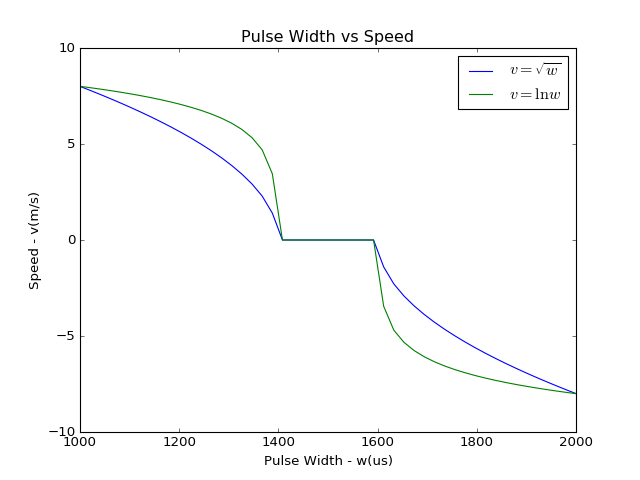

In [4]:
def pulse_width_to_speed(w):
    v1 = 8.0 * (np.sqrt((w < 1400) * (1400 - w)) \
        -np.sqrt((w > 1600) * (w - 1600)))/np.sqrt(400)
    #v1 = np.random.normal(v1, SPEED_NOISE)
    v2 = 8.0 * (np.log(1 + (w < 1400) * (1400 - w)) \
        -np.log(1 + (w > 1600) * (w - 1600)))/np.log(400)
    #v2 = np.random.normal(v2, SPEED_NOISE)
    return (v1, v2)

w = np.linspace(1000, 2000)
v1, v2 = pulse_width_to_speed(w)
fig, ax = plt.subplots()
ax.plot(w, v1, label=r'$v = \sqrt{w}$')
ax.plot(w, v2, label=r'$v = \ln w$')
ax.set_title('Pulse Width vs Speed')
ax.set_xlabel('Pulse Width - w(us)')
ax.set_ylabel('Speed - v(m/s)')
ax.legend()
plt.show()

`sqrt` is more similar to actual data.

In [5]:
class SpeedMeter:
    def __init__(self, func_type='sqrt'):
        self.__func_type = func_type
        
    def read(self, w):
        v = 0.0
        if self.__func_type == 'sqrt':
            v = 8.0 * (np.sqrt((w < 1400) * (1400 - w)) \
                -np.sqrt((w > 1600) * (w - 1600)))/np.sqrt(400) 
        elif self.__func_type == 'ln':
            v = 8.0 * (np.log(1 + (w < 1400) * (1400 - w)) \
                -np.log(1 + (w > 1600) * (w - 1600)))/np.log(400)
            
        v = np.random.normal(v, SPEED_NOISE)
        return v

### `DistanceMeter` class

In [6]:
class DistanceMeter:
    def __init__(self, robot, path):
        self.__index = 0
        self.__robot = robot
        self.__path = path[:, 0:2]
        self.__speed_hints = path[:, -1]
        
    def read_cross_track_distance(self):
        r = self.__robot
        p = self.__path
        i = self.__index
        p0p = (r.x - p[i][0], r.y - p[i][1])
        p0p1 = (p[i+1][0] - p[i][0], p[i+1][1] - p[i][1])
        p0p1_len_squared = p0p1[0] ** 2 + p0p1[1] ** 2
        b = (p0p[0]*p0p1[0] + p0p[1]*p0p1[1]) / p0p1_len_squared
        c = (p0p1[0]*p0p[1] - p0p1[1]*p0p[0]) / np.sqrt(p0p1_len_squared)   
        if b > 1.0 and i < (len(p) - 2):
            self.__index += 1
        return c
    
    def goal_reached(self):
        goal = self.__path[-1]
        r = self.__robot
        dist =  np.sqrt((float(goal[0]) - r.x) ** 2 + (float(goal[1]) - r.y) ** 2)
        return dist < ROBOT_GOAL_SENSITIVITY
    
    def get_speed_hint(self):
        return self.__speed_hints[self.__index]

## `SpeedRecommender` class

In [7]:
class SpeedRecommender:
    def __init__(self, distance_meter):
        self.__distance_meter = distance_meter
    
    def get_recommended_speed(self):
        speed = self.__distance_meter.get_speed_hint()
        #speed = 1.5
        return min(speed, DESIRED_MAX_SPEED)

### `PID` class

In [8]:
class PID:
    def __init__(self, Kp, Ki, Kd, minout, maxout):
        assert minout < maxout, "minout should be smaller than maxout"
        self.__coeffs = (float(Kp), float(Ki), float(Kd))
        self.__windups = (float(minout), float(maxout))
        self.__sumerr = 0.0
        self.__preverr = 0.0
    
    def update(self, desired, measured, period):
        err = desired - measured
        self.__sumerr += self.__coeffs[1] * err * period
        self.__sumerr = min(self.__sumerr, self.__windups[1])
        self.__sumerr = max(self.__sumerr, self.__windups[0])
        pterm = self.__coeffs[0]*err
        iterm = self.__sumerr
        dterm = self.__coeffs[2]*(err - self.__preverr)/period
        self.__preverr = err
        out =  pterm + iterm + dterm
        out = min(out, self.__windups[1])
        out = max(out, self.__windups[0])
        return out

### Waypoints

<IPython.core.display.Javascript object>


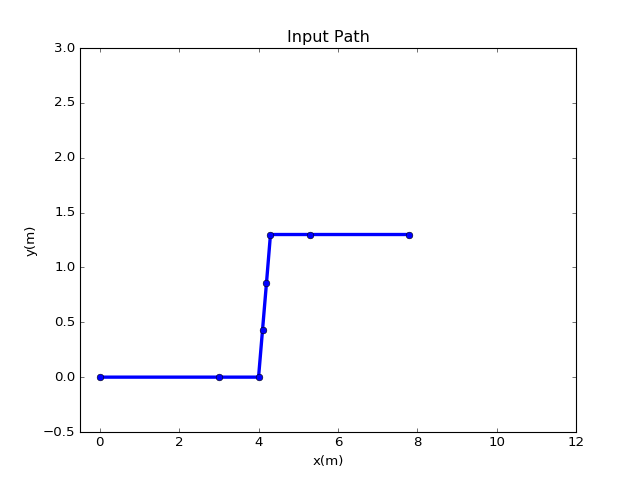

In [9]:
waypoints = np.array(
               [[0.00,  0.00, 1.00],
                [3.00,  0.00, 0.50],
                [4.00,  0.00, 1.00],
                [4.10,  0.43, 0.50],
                [4.20,  0.86, 0.50],
                [4.30,  1.30, 0.50],
                [5.30,  1.30, 1.00],
                [7.80,  1.30, 0.00]])

fig, ax = plt.subplots()
ax.set_xlim((-0.5, 12.0))
ax.set_ylim((-0.5, 3.0))
ax.set_title('Input Path')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.plot(waypoints[:,0], waypoints[:,1],'o-',lw=3)
plt.show()

### Smoothing

It should be easier to track a smooth path. We can use gradient descent to get a smoother path out of initial waypoints.

Let $p_i$ be the initial waypoints and $q_i$ is the smoothed path where subscript $i$ is the index of waypoints.
We need to minimize $(q_i - p_i)^2$ and $(q_{i+1} - q_i)^2$ together.

$$\begin{align}
q_i &= q_i - \alpha (q_i - p_i) \\
q_i &= q_i - \beta (2 q_i - q_{i+1} - q_{i-1})
\end{align}$$

where $\alpha$ and $\beta$ are data weight and smooth weight, respectively.

[[ 0.         0.         1.       ]
 [ 2.         0.         0.5      ]
 [ 3.05       0.215      1.       ]
 [ 3.625      0.5375     0.5      ]
 [ 3.9625     0.91875    0.5      ]
 [ 4.63125    1.109375   0.5      ]
 [ 6.215625   1.2046875  1.       ]
 [ 7.8        1.3        0.       ]]


<IPython.core.display.Javascript object>


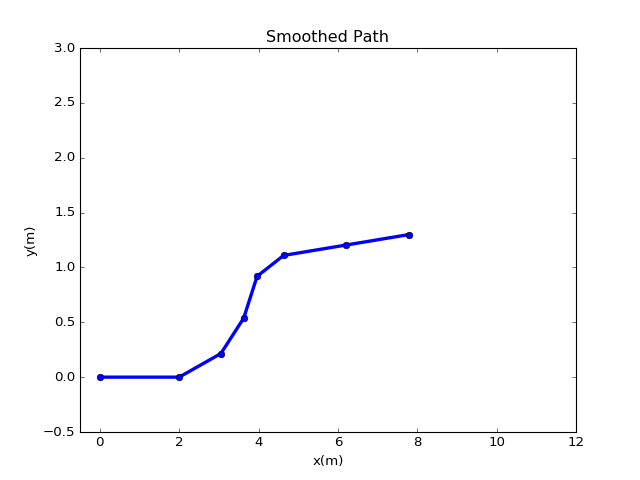

In [10]:
def smooth(waypoints, alpha=0.6, beta=0.5, tolerance=0.00000001):
    path = np.copy(waypoints)
    q = path[:, 0:2]
    p = waypoints[:, 0:2]
    change = tolerance
    while change >= tolerance:
        change = 0.0
        for i in range(1, len(p)-1):
            qold = q[i]
            q[i] -= alpha * (q[i] - p[i])
            q[i] -= beta  * (2.0 * q[i] - q[i+1] - q[i-1])
            change += abs(qold[0] - q[i][0]) + abs(qold[1] - q[i][1])
    return path

path = smooth(waypoints)
print(path)
fig, ax = plt.subplots()
ax.set_xlim((-0.5, 12.0))
ax.set_ylim((-0.5, 3.0))
ax.set_title('Smoothed Path')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.plot(path[:,0], path[:,1],'o-',lw=3)
plt.show()

### Robot Trace

In [11]:
def run(waypoints, speed_p, speed_i, speed_d,
        steering_p, steering_i, steering_d,
        speed_meter_type = 'sqrt',
        freq = 1000,             # Hz
        duration=40,             # s
        should_plot=False):
    
    def map(x, in_min, in_max, out_min, out_max):
        x = float(x)
        return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min;
    
    steering_cost = 0.0
    speed_cost = 0.0
    reached = False
    speed_desired = 0.0
    speed_measured = 0.0
    speed_command_raw = 0.0
    speed_command = 0
    ctd_desired = 0.0
    ctd_measured = 0.0
    steering = 0.0
    steering_command = 0
    
    robot = Robot(ROBOT_LENGTH)
    robot.set_pose(0.0, 0.0, 0.0)
    speed_meter = SpeedMeter(speed_meter_type)
    distance_meter = DistanceMeter(robot, waypoints)
    speed_recommender = SpeedRecommender(distance_meter)
    speed_pid = PID(speed_p, speed_i, speed_d, SPEED_COMMAND_FORWARD, SPEED_COMMAND_NEUTRAL)
    steering_pid = PID(steering_p, steering_i, steering_d, STEERING_RIGHT, STEERING_LEFT)
    period = 1.0/freq
    t = np.arange(0, duration, period)
    if should_plot:
        trace = np.zeros([len(t), 2])
        measured_speeds = np.zeros_like(t)
        desired_speeds = np.zeros_like(t)
        
    for n in range(len(t)):
        if distance_meter.goal_reached():
            reached = True
            
        robot.update_pose(steering, speed_measured, period)
        speed_desired = speed_recommender.get_recommended_speed() * (not reached)
        if n % 40 == 0:
            # 25 Hz Task
            T = 40.0 * period
            speed_measured = speed_meter.read(speed_command)
            speed_command_raw = speed_pid.update(speed_desired, speed_measured, T)
            speed_command = map(speed_command_raw,
                                 SPEED_COMMAND_FORWARD, SPEED_COMMAND_NEUTRAL,
                                 SPEED_COMMAND_NEUTRAL, SPEED_COMMAND_FORWARD)
            # `speed_command` is applied to motor now
            
        if n % 50 == 0:
            # 20 Hz Task
            T = 50.0 * period
            ctd_measured = distance_meter.read_cross_track_distance()
            steering = steering_pid.update(ctd_desired, ctd_measured, T)
            steering_command = map(steering, 
                                   STEERING_RIGHT, STEERING_LEFT,
                                   STEERING_COMMAND_RIGHT, STEERING_COMMAND_LEFT)
            # `speed_command` is applied to motor now
        
        speed_cost += (speed_desired - speed_measured) ** 2
        steering_cost += (ctd_desired - ctd_measured) ** 2
        if should_plot:
            trace[n] = [robot.x, robot.y]
            measured_speeds[n] = speed_measured
            desired_speeds[n]  = speed_desired
            
    if not speed_measured == 0.0:
        # Didn't stop when time was out
        speed_cost *= 10.0
    if not reached:
        # Goal is not reached
        steering_cost *= 10.0
        
    if should_plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=plt.figaspect(0.5))
        ax1.set_xlim((-0.5, 12.0))
        ax1.set_ylim((-0.5, 3.0))
        ax1.set_title('Trace vs Input Path')
        ax1.set_xlabel('x(m)')
        ax1.set_ylabel('y(m)')
        ax1.plot(waypoints[:,0], waypoints[:,1],'o-',lw=3, label='input')
        ax1.plot(trace[:,0], trace[:,1], '--', lw=3, label='trace')
        ax1.legend()
        ax2.set_ylim((0, 2.0))
        ax2.set_title('Measured vs Desired Speed')
        ax2.set_xlabel('Time(s)')
        ax2.set_ylabel('Velocity(m/s)')
        ax2.plot(t, desired_speeds, label='desired speed')
        ax2.plot(t, measured_speeds, label='measured speed')
        ax2.legend()
        plt.show()
        
    l = len(t)
    return (steering_cost/l, speed_cost/l)

<IPython.core.display.Javascript object>


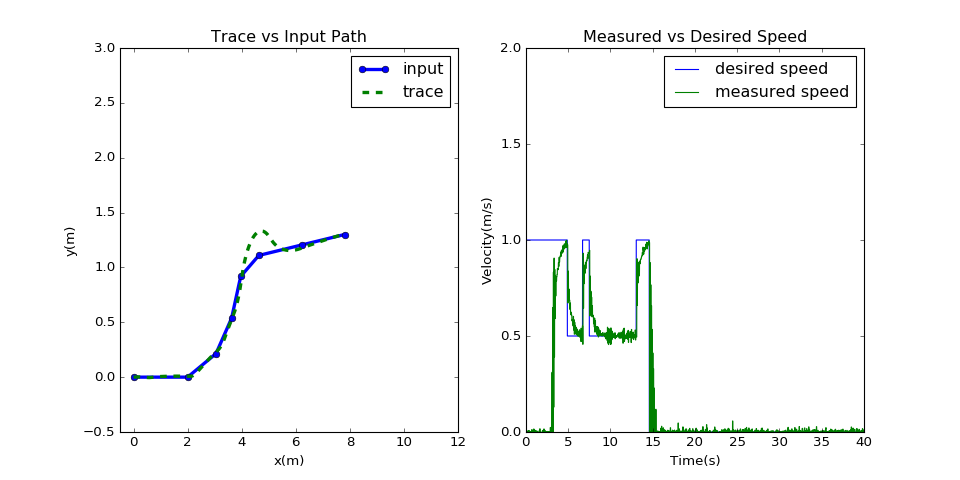

(0.0021379014696948804, 2.8228636573179409)

In [12]:
#run(waypoints, 5.42539876,  31.29200024, 0.0,   5.93277065,   7.69425523,   5.75460786, should_plot=True)
run(path, 5.42539876,  31.29200024, 0.0,   5.93277065,   7.69425523,   5.75460786, should_plot=True)

## PID Tuning using Genetic Algorithm

A chromosome (i.e. individual) is represented by $C = (P_{speed}, I_{speed}, P_{steering}, I_{steering}, D_{steering})$ where elements are the speed and steering PID coefficients, respectively.

**Remark:** Notice that $D_{speed}$ is missing in the chromosome representation. It is always zero, so that speed controller is effectively a PI controller.

Cost function $J(C)$ is given as follows.

$$\begin{align}
J(C) = p_vm\sum( v_d - v_m)^2 + p_cn\sum( c_d - c_m)^2
\end{align}$$

where punishment $p_v$, $p_c$ and ratio $m$, $n$ factors are expressed as

$$\begin{align}
& m + n  = 1 \\
& p_v    = 
 \begin{cases}
      10,           &  \text{measured speed is not zero when time is out } \\
      1,           &  \text{otherwise } \\
   \end{cases} \\
& p_c   = 
 \begin{cases}
      10, & \text{goal is not reached when time is out } \\
      1,  & \text{otherwise } \\
   \end{cases} \\
\end{align}$$

Fitness function $F(C)$ is defined as
$$\begin{align}
F(C) = \frac{1}{J(C) + 1}
\end{align}$$

**Remark:** Note that due to the gaussian noise, fitness function gives slightly different results.

First individual is selected by best-fit selection with a probability of 50%, or by roulette wheel with 50%.
Second individual is always selected by roulette wheel selection. These two undergo a crossover operation. New individual is constructed by randomly weighted sum of each gene of the parents. Mutation operator with a probability of 5% is also used.

In [11]:
# Cost function
def J(individual):
    steering_cost, speed_cost = run(waypoints, individual[0], individual[1], 0.0,
                            individual[2], individual[3], individual[4])
    c = 0.5*steering_cost + 0.5*speed_cost 
    return c
# Fitness calculated using the cost function
def fitness(individual):
    c = J(individual)
    f = 1.0/(c + 1.0)
    return (c, f)
    
# individual1: 50% best fit, 50% roulette wheel
# individual2: always roulette wheel
def select(population, fitnesses):
    cumulative = sum(fitnesses)

    index1 = 0
    if np.random.randint(0, 100) < 50:
        index1 = fitnesses.index(max(fitnesses))
    else:
        index1 = 0
        s = 0
        r = np.random.rand() * cumulative # [0, cumulative)
        for i, f in enumerate(fitnesses):
            if s >= r:
                index1 = i
                break;
            s += f
        
    index2 = 0
    s = 0
    r = np.random.rand() * cumulative # [0, cumulative)
    for i, f in enumerate(fitnesses):
        if s >= r:
            index2 = i
            break;
        s += f
    return (population[index1], population[index2])

# n-point crossover
def crossover(individual1, individual2):
    individual = np.zeros_like(individual1)
    for i in range(len(individual)):
        r = np.random.rand()
        individual[i] = individual2[i]*r + individual1[i]*(1.0-r)
    return individual

# Muatation with probability of 5%
def mutate(individual):
    i = np.random.randint(0, len(individual))
    r = np.random.randint(0, 100)
    k = 1.0
    if  r < 5:
        k = np.random.normal(1.0, 1.0)
    individual[i] *= abs(k)
    return individual
    
# Genetic algorithm loop
def genetic_algorithm(population, iteration=100):
    fitnesses = []
    averages = []
    for individual in population:
        fitnesses.append(fitness(individual)[1])
        averages.append(sum(fitnesses) / len(fitnesses))
    for i in range(iteration):
        (individual1, individual2) = select(population, fitnesses)
        individual = crossover(individual1, individual2)
        individual = mutate(individual)
        (c, f) = fitness(individual)
        population.append(individual) 
        fitnesses.append(f)
        size = len(averages)
        total = averages[-1] * size + f
        averages.append(total/(size + 1))
    return (averages, fitnesses, population[fitnesses.index(max(fitnesses))])

best:  [  5.42539876  31.29200024   5.93277065   7.69425523   5.75460786] (1.3329028054090737, 0.42865051972220952)


<IPython.core.display.Javascript object>


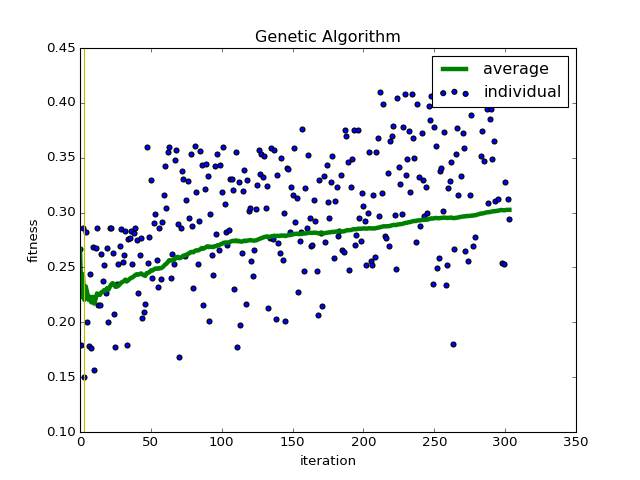

In [425]:
# Randomly generate individuals
population = (np.random.rand(4, 5)*10.0) # 4 individuals of coeffs range [0, 10)
population = population.tolist()
(averages, fitnesses, best) = genetic_algorithm(population, iteration=300)
print('best: ', best, (fitness(best)))
fig, ax = plt.subplots()
ax.scatter(range(0, len(fitnesses)), fitnesses, label='individual')
ax.plot(averages, color="g", lw=4, label='average')
ax.axvline(x=3, linewidth=1, color='y')
ax.set_title('Genetic Algorithm')
ax.set_xlabel('iteration')
ax.set_ylabel('fitness')
ax.set_xlim(left=0.0)
ax.legend()
plt.show()